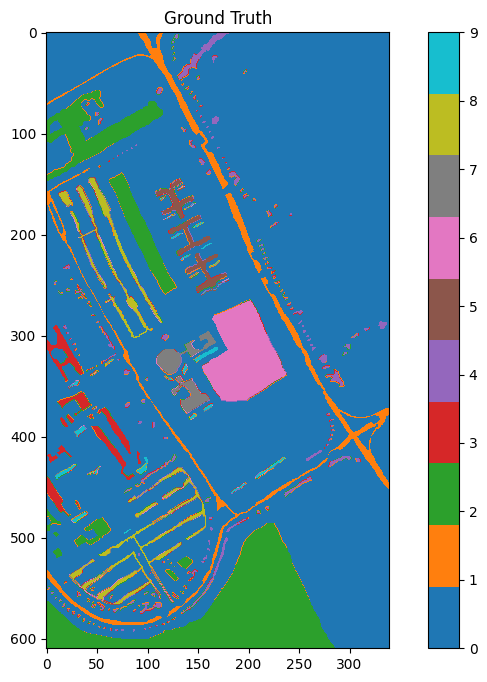

In [1]:

import scipy.io
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier



image_path = 'C:\\Users\\30674\\Desktop\\dts201 pattern revognition\\Team Coursework\\DTS201TC CW DATASET\\PaviaU' 
gt_path ='C:\\Users\\30674\\Desktop\\dts201 pattern revognition\\Team Coursework\\DTS201TC CW DATASET\\PaviaU_gt'  
image = scipy.io.loadmat(image_path)
image = image['paviaU'] # 读取图像数据
# 读取ground truth（假设ground truth是单通道灰度图像）

ground_truth = scipy.io.loadmat(gt_path)
ground_truth = ground_truth['paviaU_gt'] # 读取ground truth数据

cmap = plt.get_cmap('tab10')  # 这里使用tab20颜色映射，你可以根据需要选择其他颜色映射

# 绘制Ground Truth 图像
plt.figure(figsize=(10, 8))
plt.imshow(ground_truth, cmap=cmap, vmin=0, vmax=9)  # 假设分类标签从0到9
plt.colorbar()
plt.title('Ground Truth')
plt.show()

In [2]:



#flattten the image to 1-d vecctor 
image_data = image.reshape(-1, 103)
print(image_data.shape)


#flattten the ground truth to 1-d vecctor
gt_data = ground_truth.reshape(-1)
non_zero_indices = np.where(gt_data != 0)

image_data= image_data[non_zero_indices]
image_data_copy = image_data.copy()


gt_data = gt_data[non_zero_indices]
print(min(gt_data))

(207400, 103)
1


In [3]:

scaler = StandardScaler()
image_data = scaler.fit_transform(image_data)

In [4]:

#use random forest classifier to get the feature importance
best_n_estimators = 100
best_num_features = 0
num_features_list = []
best_select_features = None
for n in range(100,201,50):
    rf = RandomForestClassifier(n_estimators=n)
    rf.fit(image_data, gt_data)

    
    #get the importance of each feature
    feature_importance = rf.feature_importances_

  
    #select the threshold for feature selection
    threshold = np.median(feature_importance)


    #select the features based on the threshold
    selected_features = np.where(feature_importance > threshold)[0]
    
    num_features_list.append(len(selected_features))

    
    #check if n_estimators gives more selected features
    if len(selected_features) > best_num_features:
        best_num_features = len(selected_features)
        best_n_estimators = n
        best_select_features = selected_features


print(f"the best n_estimators is {best_n_estimators}, select {best_num_features} features")
image_data = image_data[:, best_select_features]


the best n_estimators is 100, select 51 features


In [5]:
class Bayes:
    def __init__(self, classifier=GaussianNB(), gt_data=gt_data):
        self.classifer =classifier
        
        self.gt_data = gt_data
    def solution(self,image_data,plot:bool=False):

        

        #split the dataset
        X_train, X_test, y_train, y_test = train_test_split(image_data, self.gt_data, test_size=0.2, random_state=100, stratify=gt_data)


        #create the GaussianNB classifier
        nb_classifier = self.classifer

        #fit the model
        nb_classifier.fit(X_train, y_train)


        #make predictions
        y_pred = nb_classifier.predict(X_test)

        #evaluate the performance
        accuracy = accuracy_score(y_test, y_pred)
        
        if plot:

            #change the labels of y_test and y_pred
            y_test += 1
            y_pred += 1

            f1 = f1_score(y_test, y_pred, average=None)
            precision = precision_score(y_test, y_pred, average=None)
            recall = recall_score(y_test, y_pred, average=None)

            #output the evaluation metrics for each class # 修改unique_labels的范围

            #buile the confusion matrix
            confusion = confusion_matrix(y_test, y_pred) 
            #build the classification report
            class_report = classification_report(y_test, y_pred)
            print("Classification Report:")
            print(class_report)
            
            
            
            #use Seaborn to plot the heat map of confusion matrix
            plt.figure(figsize=(7, 7))
            sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=[1,2,3,4,5,6,7,8,9], yticklabels=[1,2,3,4,5,6,7,8,9])  #plot the confusion matrix
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.title("Confusion Matrix")
            plt.show()
        return accuracy

**PCA Cross validation**

In [6]:
import time
bayes_result=[]
bayes=Bayes()
# use PCA to run the validation and determine the best dimension
for i in range (51):
    
    # utilize PCA to reduce the dimension of the image data
    pca = PCA(n_components=i+1)
    image_data_pca = pca.fit_transform(image_data)# 读取图像
   
    # record the accuracy of each dimension
    acc=bayes.solution(image_data_pca)
    bayes_result.append(acc)
    
    


when the dimension=38,it achieve accuracy of 0.833216456287985
37


Text(0, 0.5, 'accuracy')

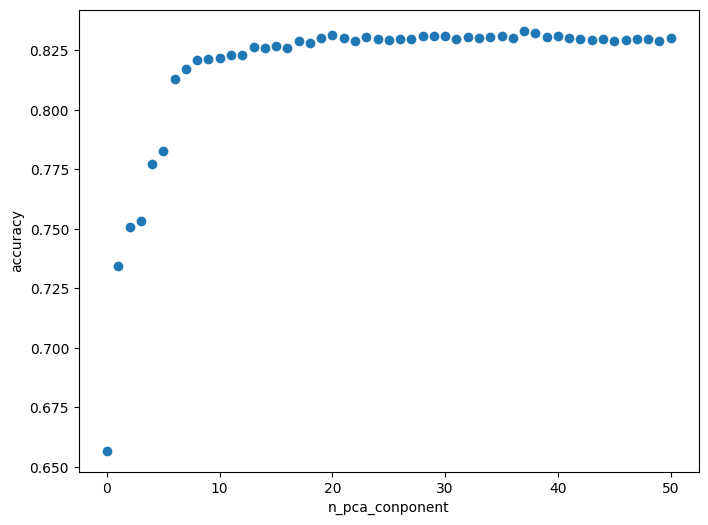

In [7]:
# calculate the max accuracy and the corresponding dimension
max=np.argmax(bayes_result)
print(f"when the dimension={max+1},it achieve accuracy of {np.max(bayes_result)}")
print(max)

#plot the accuracy of each dimension
plt.figure(figsize=(8, 6))
plt.scatter(range(51),bayes_result)
plt.xlabel("n_pca_conponent")
plt.ylabel("accuracy")

**LDA Cross Validation**

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# max_n_components for LDA is the number of classes - 1
max_n_components = len(np.unique(gt_data)) - 1

LDA_dimensions = range(1,max_n_components+1)


accuracy=[]
bayes=Bayes()
# use LDA to run the validation and determine the best dimension
for n in LDA_dimensions:
    LDA = LinearDiscriminantAnalysis(n_components=n)
    X_LDA = LDA.fit_transform(image_data, gt_data)
    #record the accuracy of each dimension
    acc=bayes.solution(X_LDA)
    accuracy.append(acc)
#print(accuracies)

# calculate the max accuracy and the corresponding dimension
max_LDA_dimension = np.argmax(accuracy) + 1
print(f"the best LDA dimension is {max_LDA_dimension}")
print(f"the max accuracy is {accuracy[max_LDA_dimension-1]}")

#plt.figure(figsize=(15,15))



the best LDA dimension is 8
the max accuracy is 0.868630201028518


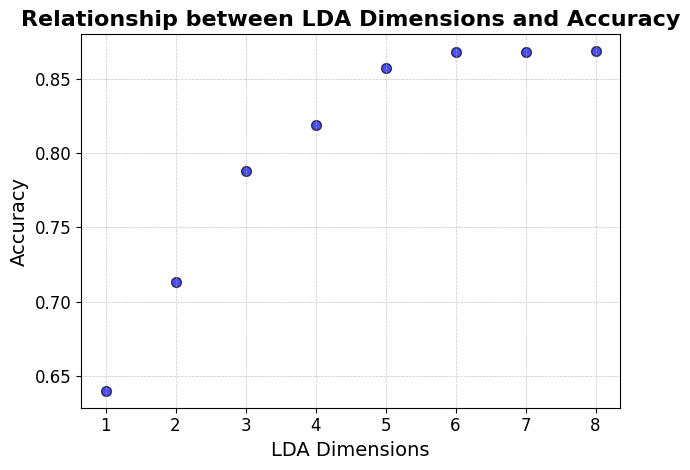

In [9]:
# 创建图形和轴对象
# Create figure and axis objects
fig, ax = plt.subplots()

# 散点图
# plot the Scatter plot
ax.scatter(LDA_dimensions, accuracy, color='blue', s=50, edgecolors='black', alpha=0.7)

# 添加标题和轴标签
# Add title and axis labels
ax.set_title("Relationship between LDA Dimensions and Accuracy", fontsize=16, fontweight='bold')
ax.set_xlabel("LDA Dimensions", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)

# 设置坐标轴刻度字体大小
# Set tick font size for axes
ax.tick_params(axis='both', labelsize=12)

# 添加背景网格线
# Add background grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)


plt.tight_layout()  
plt.show()

**Evaluation Metrics For Bayes with LDA**


Classification Report:
              precision    recall  f1-score   support

           2       0.93      0.91      0.92      1326
           3       0.91      0.92      0.91      3730
           4       0.76      0.60      0.67       420
           5       0.80      0.95      0.86       613
           6       0.94      1.00      0.97       269
           7       0.76      0.70      0.73      1006
           8       0.87      0.83      0.85       266
           9       0.75      0.82      0.78       737
          10       1.00      0.98      0.99       189

    accuracy                           0.87      8556
   macro avg       0.86      0.86      0.85      8556
weighted avg       0.87      0.87      0.87      8556



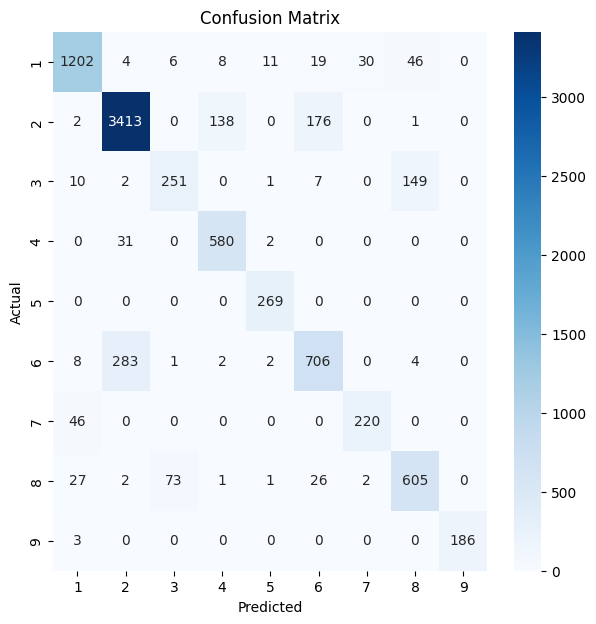

0.868630201028518

In [10]:
bayes=Bayes()
LDA = LinearDiscriminantAnalysis(n_components=n)
X_LDA = LDA.fit_transform(image_data, gt_data)
# use plot=True to plot the confusion matrix
bayes.solution(X_LDA,plot=True)
